# Explained Variance Ratio (PCA)

In [2]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Configuración general para Windows
os.environ["OMP_NUM_THREADS"] = "2"
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== ANÁLISIS PCA: REDUCCIÓN DE DIMENSIONALIDAD Y MODELOS ===\n")


=== ANÁLISIS PCA: REDUCCIÓN DE DIMENSIONALIDAD Y MODELOS ===



In [4]:
# Generar datos de alta dimensión
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=12,
    n_clusters_per_class=1,
    random_state=42
)

# Convertir a DataFrame para análisis visual
feature_names = [f'Feature_{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dimensiones originales: {X.shape}")
print(f"Número de clases: {len(np.unique(y))}")


Dimensiones originales: (1000, 20)
Número de clases: 2


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nDatos estandarizados correctamente (media ~0, varianza ~1).")



Datos estandarizados correctamente (media ~0, varianza ~1).


In [8]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("\n=== EXPLAINED VARIANCE RATIO POR COMPONENTE ===")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print("\n=== VARIANZA ACUMULADA ===")
print(f"Primeros 5 componentes: {cumulative_variance_ratio[4]:.4f} ({cumulative_variance_ratio[4]*100:.2f}%)")
print(f"Primeros 10 componentes: {cumulative_variance_ratio[9]:.4f} ({cumulative_variance_ratio[9]*100:.2f}%)")



=== EXPLAINED VARIANCE RATIO POR COMPONENTE ===
PC1: 0.3455 (34.55%)
PC2: 0.2032 (20.32%)
PC3: 0.1517 (15.17%)
PC4: 0.1183 (11.83%)
PC5: 0.1085 (10.85%)
PC6: 0.0512 (5.12%)
PC7: 0.0180 (1.80%)
PC8: 0.0036 (0.36%)
PC9: 0.0000 (0.00%)
PC10: 0.0000 (0.00%)

=== VARIANZA ACUMULADA ===
Primeros 5 componentes: 0.9272 (92.72%)
Primeros 10 componentes: 1.0000 (100.00%)


In [10]:
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nComponentes necesarios para explicar el 95% de la varianza: {n_components_95}")



Componentes necesarios para explicar el 95% de la varianza: 6


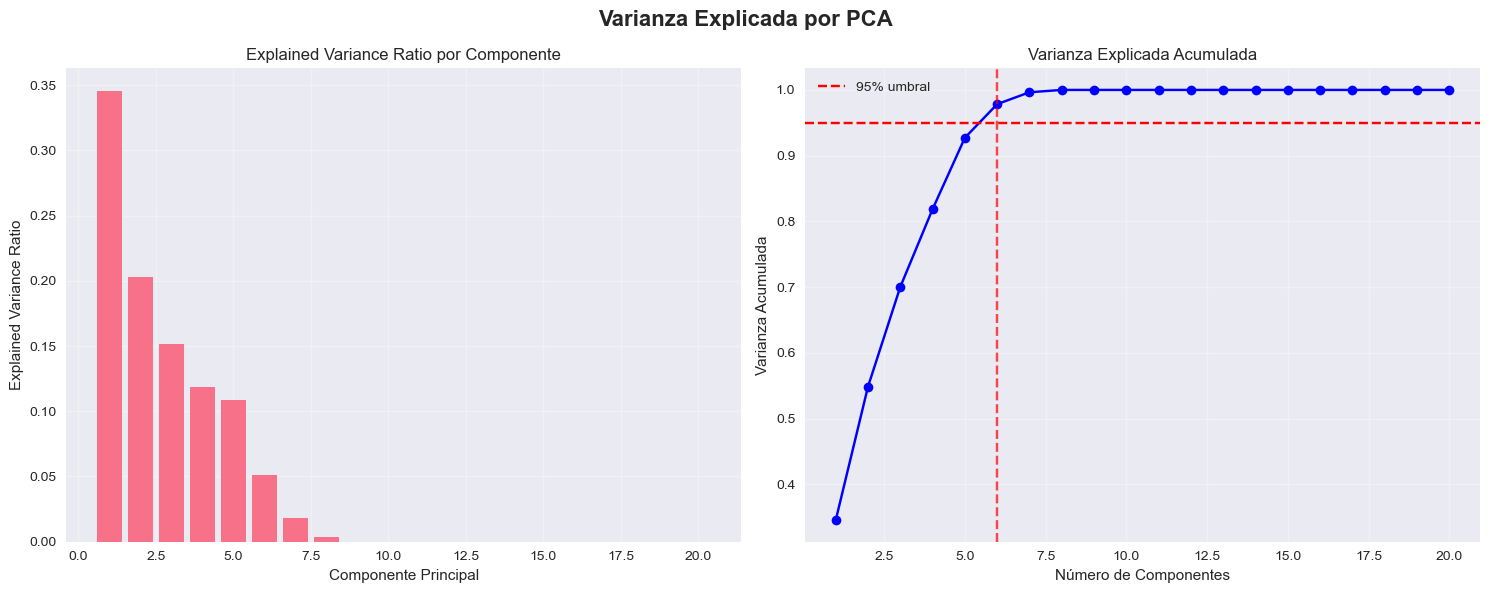

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Varianza Explicada por PCA", fontsize=16, fontweight='bold')

# --- Gráfico 1: Explained Variance Ratio ---
axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
axes[0].set_title('Explained Variance Ratio por Componente')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(True, alpha=0.3)

# --- Gráfico 2: Varianza acumulada ---
axes[1].plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% umbral')
axes[1].axvline(x=n_components_95, color='red', linestyle='--', alpha=0.7)
axes[1].set_title('Varianza Explicada Acumulada')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Modelo base (sin PCA)
model_original = LogisticRegression(random_state=42, max_iter=1000)
model_original.fit(X_train, y_train)
accuracy_original = accuracy_score(y_test, model_original.predict(X_test))

# Modelo con PCA reducido
pca_reduced = PCA(n_components=n_components_95)
X_train_pca = pca_reduced.fit_transform(X_train)
X_test_pca = pca_reduced.transform(X_test)

model_pca = LogisticRegression(random_state=42, max_iter=1000)
model_pca.fit(X_train_pca, y_train)
accuracy_pca = accuracy_score(y_test, model_pca.predict(X_test_pca))


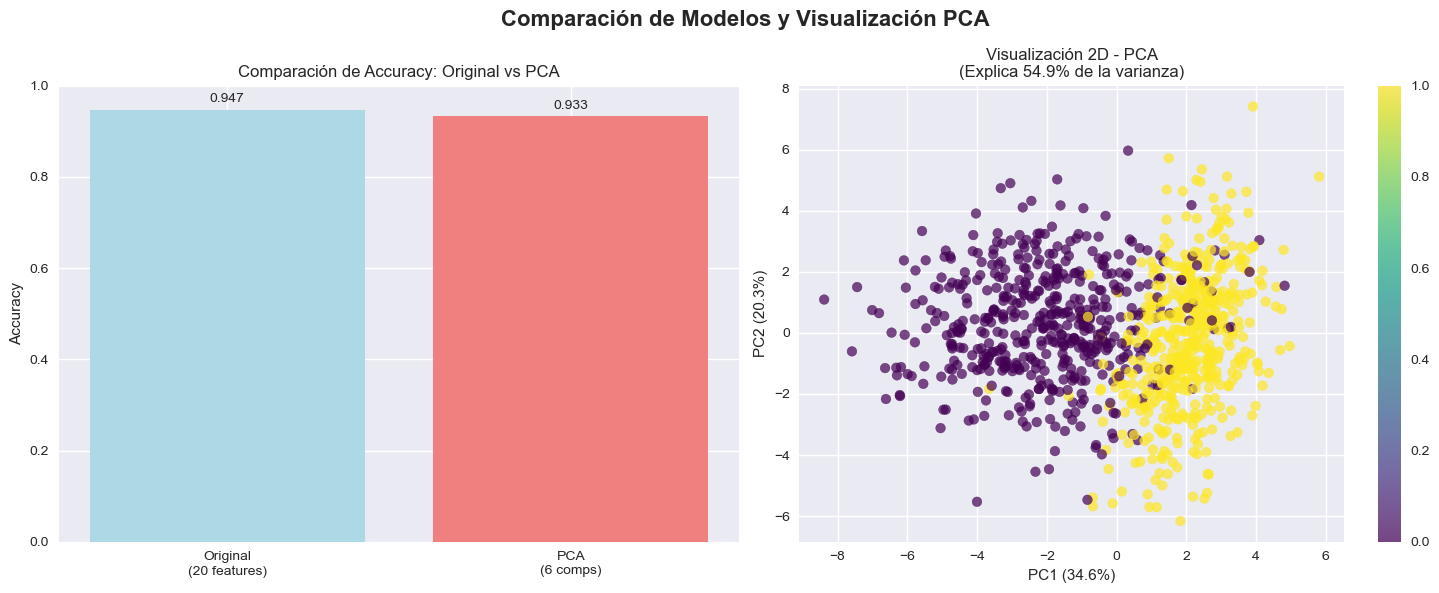

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Comparación de Modelos y Visualización PCA", fontsize=16, fontweight='bold')

# --- Gráfico 1: Accuracy ---
models = ['Original\n(20 features)', f'PCA\n({n_components_95} comps)']
accuracies = [accuracy_original, accuracy_pca]
colors = ['lightblue', 'lightcoral']

bars = axes[0].bar(models, accuracies, color=colors)
axes[0].set_title('Comparación de Accuracy: Original vs PCA')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{acc:.3f}', ha='center', va='bottom')

# --- Gráfico 2: Proyección 2D ---
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

scatter = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1].set_title(f'Visualización 2D - PCA\n(Explica {cumulative_variance_ratio[1]*100:.1f}% de la varianza)')
axes[1].set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}%)')
plt.colorbar(scatter, ax=axes[1])

plt.tight_layout()
plt.show()


In [18]:
print("\n=== ANÁLISIS DETALLADO ===")
print(f"Dimensiones reducidas: {X_train_pca.shape[1]} (reducción del {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.1f}%)")
print(f"Accuracy modelo original: {accuracy_original:.4f}")
print(f"Accuracy modelo PCA: {accuracy_pca:.4f}")
print(f"Diferencia de accuracy: {accuracy_original - accuracy_pca:.4f}")
print(f"Varianza conservada: {cumulative_variance_ratio[n_components_95-1]*100:.2f}%")



=== ANÁLISIS DETALLADO ===
Dimensiones reducidas: 6 (reducción del 70.0%)
Accuracy modelo original: 0.9467
Accuracy modelo PCA: 0.9333
Diferencia de accuracy: 0.0133
Varianza conservada: 97.84%


In [20]:
summary_data = {
    'Componente': [f'PC{i+1}' for i in range(min(10, len(explained_variance_ratio)))],
    'Explained Variance Ratio': [f'{ratio:.4f}' for ratio in explained_variance_ratio[:10]],
    'Varianza Acumulada': [f'{cum:.4f}' for cum in cumulative_variance_ratio[:10]],
    'Porcentaje Acumulado': [f'{cum*100:.2f}%' for cum in cumulative_variance_ratio[:10]]
}

summary_df = pd.DataFrame(summary_data)

print("\n=== TABLA RESUMEN (Primeros 10 componentes) ===")
display(summary_df)



=== TABLA RESUMEN (Primeros 10 componentes) ===


,Componente,Explained Variance Ratio,Varianza Acumulada,Porcentaje Acumulado
0,PC1,0.3455,0.3455,34.55%
1,PC2,0.2032,0.5487,54.87%
2,PC3,0.1517,0.7004,70.04%
3,PC4,0.1183,0.8187,81.87%
4,PC5,0.1085,0.9272,92.72%
5,PC6,0.0512,0.9784,97.84%
6,PC7,0.0180,0.9964,99.64%
7,PC8,0.0036,1.0000,100.00%
8,PC9,0.0000,1.0000,100.00%
9,PC10,0.0000,1.0000,100.00%
